# Know your trees - 8 practical insights for training decision trees

Tree based algorithms are among the most widely used algorithms in machine learning. This popularity is due largely to tree based algorithms being capable of achieving good results "out of the box", that is, with little tuning or data processing. Additionally tree based methods are versitile. They can be applied to both classification and regression problems and easily support mixing categorical and numeric values. Additionally algorithms such as the Random Forest inherits all of these benefits and are robust against overfitting making it an ideal candidate for almost any problem. This post will take a look at 7 properties of Decision Trees and offer practical insights on how to use these properties to get the most out of trees.

Note: this post is probably most suited to someone who already understands the basic idea of a decision tree and has used trees in practice before. However if you've been doing data science for a while it's unlikely that you will discover anything new from this post.

# Preliminaries

Before getting started we'll load up the clasic [Titanic data set](https://www.kaggle.com/c/titanic) to use for examples along the way

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import matplotlib.pyplot as plt
import numpy as np
import utils
X, y = utils.load_data()  # titanic data

# Scale Invariance

The first topic up is *scale invariance*. This means that training results are unaffected by [monotonic transformations](https://en.wikipedia.org/wiki/Monotonic_function) to the data set, that is transformations that preserve a feature's order, or said yet another way $x_{1}<x_{2}\rightarrow f(x_{1})<f(x_{2})$.

In other words normalizing or taking the log of a feature will have no impact on the outcome of training whatsoever. This makes training decision trees somewhat easier to train than, say, gradient based models which are much more sensitive to the scale of a data set and require normalization.

The following code snippet demonstrates this property.

In [2]:
clf1 = DecisionTreeClassifier()
clf2 = DecisionTreeClassifier()
clf1.fit(X, y)
Xt = X.copy()
Xt['Age'] /= 2
Xt['Fare'] = np.log10(Xt.Fare+1e-1)
clf2.fit(Xt, y)
(clf1.predict(X) == clf2.predict(Xt)).all()

True

We can get some insight into this property by examining how decision trees are learned. The following pseudo-Python code shows how the best split is determined for a given node.

```python
scores = {}
for J in features:
    for j in set(X[J]):
        x1 = [x for x in X.records if x[J] < j]
        x2 = [x for x in X.records if x[J] >= j]
        scores[(J, j)] = f(x1, x2)
best_split = max(scores.items(), key=lambda x: x[1])
(feature, value), score = best_split
```

In other words the best split is the one that optimizes an objective function whose input is the subsets of the data belonging to the child nodes of the corresponding split. Two of the most common functions used are [Gini impurity and Information gain](https://en.wikipedia.org/wiki/Decision_tree_learning#Metrics). Each split in the decision tree is determined from the root node down (greedily).

If you look carefully at this algorithm you'll see that if `X[J]` undergoes a monotonic transformation we'll still see the same values for `x1` and `x2` as before the transformation was performed, hence decision trees are scale invariant.

### What Scale Invariance does not mean

Keep in mind that scale invariance only applies to a models *features* at *train time*. Scaling the response variable (in the case of regression) can impact training results. Similarly at *predict time* trees are still susceptible to changes in scale resulting from, e.g., covariate drift (see my previous [blog post](https://dantegates.github.io/2018/06/12/Monitoring-machine-learning-models-in-production.html))

# Feature selection

As shown above, when fitting a decision tree all possible splits of all training features are considered. However, only splits that are useful are chosen (most training implementations stop training once the splits are no longer beneficial past a certain threshold). Thus the presence of uninformative features in the training set does not hurt performance, and in this sense decision trees perform feature selection for the user.

Consider the following example where adding completely random features to the training data has no impact on predictions.

In [3]:
clf1 = DecisionTreeClassifier()
clf2 = DecisionTreeClassifier()
clf1.fit(X, y)
Xt = pd.DataFrame(np.random.randint(1, 10, size=(len(X), 3)), columns=['rand1', 'rand2', 'rand3'])
Xt = X.merge(Xt, left_index=True, right_index=True)
clf2.fit(Xt, y)
(clf1.predict(X) == clf2.predict(Xt)).all()

True

# Limited Extrapolation

We've covered how to fit a decision tree. Now let's discuss how trees make predictions. At some point during training the algorithm above will terminate. This usually happens when (1) no more splits can be made or (2) all possible splits that remain fail to yield a score from the objective function above a certain threshold.

At predict time, we run a feature vector through the decision trees rules until it hits a terminal node. In the case of classification, the most prevalent label in the training set belonging to that terminal node is the predicted label. In the case of regression the average response value of the training set becomes the prediction.

This means trees can only predict values that were seen at train time. This is usually the case for classification. However for regression, many models are capable of predictive values lower or higher than what was seen at train time.

If you think that you may need to predict values at run time above or below what was seen at train time and you want to use a tree based method, you may be able to get away with predicting an increase or decrease in the response value.

# Non linearity

This brings us to our next point, since regression predictions are averages of the training data, we see that trees are capable of learning to predict non linear variables.

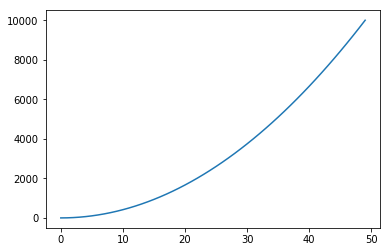

In [4]:
regressor = DecisionTreeRegressor()
X_regression = np.linspace(0, 100).reshape(-1, 1)
y_regression = X_regression.reshape(-1)**2
regressor.fit(X_regression, y_regression)
plt.plot(regressor.predict(X_regression))

# Interpretability

Decision trees have the desirable property of being easily interpretable. We can fit a decision tree and look at the actual rules learned at each node. With `sklearn` it's easy to visualize a learned decision tree.

In [5]:
clf = DecisionTreeClassifier(max_depth=5)
_ = clf.fit(X, y)

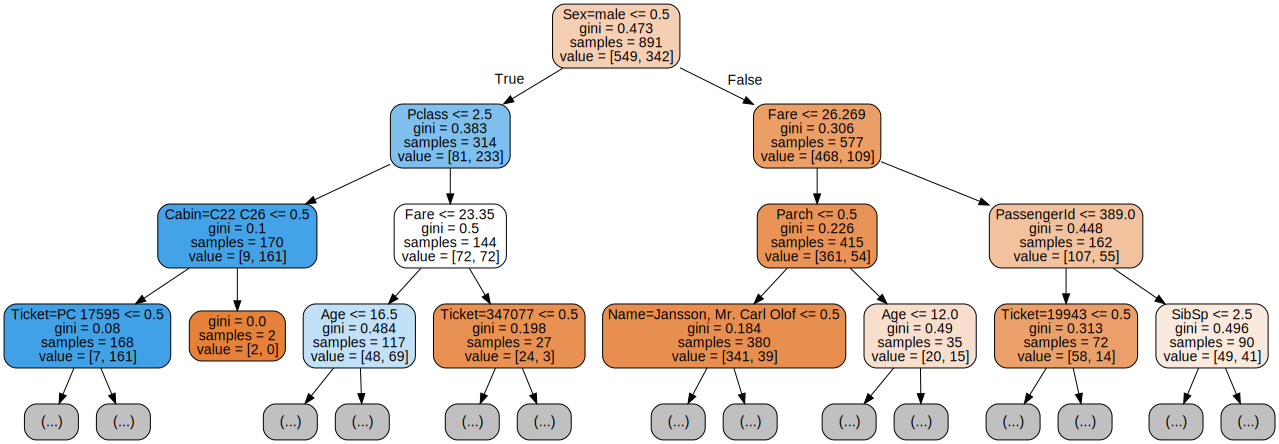

In [6]:
from sklearn.tree import export_graphviz
import graphviz
dot_graph = export_graphviz(
    clf, max_depth=3, feature_names=X.columns, out_file=None,
    filled=True, rounded=True
)
graphviz.Source(dot_graph)

In addition to understanding how the predictions are made, the fitting process gives us something called *feature importances*. Feature importance is equal to the total of the optimization function evaluated at every split for a given feature.

Trees fit with `sklearn` store feature importances in the `.feature_importances_` attribute.

In [7]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
for i, f in enumerate(indices[:15]):
    print("%d. feature %s (%f)" % (i + 1, X.columns[f], importances[f]))

1. feature Sex=male (0.526174)
2. feature Pclass (0.131783)
3. feature Fare (0.085709)
4. feature Age (0.080391)
5. feature Parch (0.036915)
6. feature SibSp (0.028413)
7. feature PassengerId (0.023065)
8. feature Cabin=C22 C26 (0.015352)
9. feature Ticket=347077 (0.014434)
10. feature Ticket=349909 (0.009070)
11. feature Ticket=2653 (0.007988)
12. feature Name=Mack, Mrs. (Mary) (0.007908)
13. feature Ticket=PC 17595 (0.007814)
14. feature Cabin=D56 (0.006865)
15. feature Name=Jansson, Mr. Carl Olof (0.006829)


## Drawing conclusions from feature importances

As a side benefit, feature importances can be used to infer the relevance of a feature to a given problem. One way to do this is to include random features in the training data. Based on the feature importances you can conclude whether a given feature is more informative than random noise.

However, be cautious in drawing conclusions about a feature based on the magnitude of its feature importance alone. The raw value itself can be deceiving.

For example if two features are highly correlated, it may be more or less arbitrary why one the first feature was chosen to split on rather than the second leading to a decrease in feature importance for both features.

Also, feature importance is the total importance of a feature for all splits. However, binary features can only be split on once while numeric features may be split on several times.

# Trees scale well

For a single instance trees have a prediction time complexity of $\text{log}_{2}(d)$ where $d$ is the depth of the tree, i.e. number of splits learned. Note that if there are $n$ training examples in your data set then $d<n$ as trees are incapable of predicting on more than one example at a time (however the algorithm itself is easily parallelizable). Additionally most implementations include a parameter for setting the maximum depth of the tree allowing you to have control over the time complexity at both train and predict time.

Tree based ensemble methods, such as the Random Forest or Gradient Boosted Trees also scale well, as the complexity is $tn\text{log}_{2}(d)$ where $t$ is the number of trees in the ensemble.

The following code shows how predict times compare to the number of features used during training.

In [8]:
import time
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

class Timer:
    def __enter__(self):
        self.start = time.time()
        return self
    def __exit__(self, *exc):
        self.stop = time.time()
    @property
    def elapsed(self):
        return self.stop - self.start

predict_times = []
predict_times_sd = []
clf = DecisionTreeClassifier()
X_scale, y_scale = make_classification(1000, n_features=4000, n_informative=3900)
for n_features in range(10, 4000, 100):
    clf.fit(X_scale[:,:n_features], y_scale)
    # take mean predict time of several trials
    trial_times = []
    for _ in range(50):
        with Timer() as timer:
            clf.predict(X_scale[:,:n_features])
        trial_times.append(timer.elapsed)
    predict_times.append(np.mean(trial_times))
    predict_times_sd.append(np.std(trial_times))

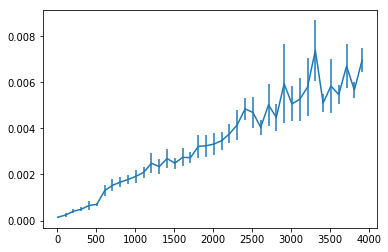

In [9]:
_ = plt.errorbar(range(10, 4000, 100), predict_times, yerr=predict_times_sd)

# Feature interactions

By now we have enough understanding into how trees work to see that they can *implicitly* learn feature interactions. For example consecutive splits on `age` and `weight` are in a certain sense accounting for the interaction of those two features.

Keep in mind however that trees are not optimized to learn feature interactions. This means that if you have some knowledge about useful interactions in your data set you should explicitly include those values at train time. Not only can this improve performance, but it can decrease the amount of train/predict time as the model can learn to partition the data using less splits.

# Susceptibility to overfitting

Note that a fully grown decision tree could possibly continue to split the data until each leaf node contains a unique feature set and label. In this case the model is unlikely to generalize. Limiting the maximum depth of the tree or number of features used are a good start to prevent overfitting. Fortunately tree based methods such as the Random Forest as robust against overfitting.